---
title: "Simulating today's hockey games"
description: "Run monte carlo simulations using the expected goals model to predict the winners of today's games"
author: "chicken"
date: "1/27/2026"
categories:
    - "tutorials"
image: charts/2026-01-24_NSH.png
lightbox: true
draft: false
---

## **Intro**

Use the `chickenstats` library to scrape play-by-play data, aggregate to the team level, then run monte 
carlo simulations to predict the winners of today's games.

Parts of this tutorial are optional and will be clearly marked as such. For help, or any questions,
please don't hesitate to reach out to [chicken@chickenandstats.com](mailto:chicken@chickenandstats.com) or
[@chickenandstats.com](https://bsky.app/profile/chickenandstats.com) on Blue Sky.

---

![](./charts/2026-01-24_NSH.png)

---

## **Housekeeping**

### Import dependencies

Import the dependencies we'll need for the guide

In [ ]:
import matplotlib.patheffects as mpe
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
import seaborn as sns

import polars as pl
import numpy as np
from scipy.stats import poisson

from pathlib import Path

import concurrent
from concurrent.futures import ThreadPoolExecutor

from chickenstats.chicken_nhl import Scraper, Season
from chickenstats.chicken_nhl._helpers import charts_directory
from chickenstats.chicken_nhl._validation import TeamSchemaPolars
from chickenstats.chicken_nhl.team import NHL_COLORS, Team
from chickenstats.utilities import ChickenProgress

### Polars options

Set different polars options. This cell is optional

In [ ]:
pl.Config.set_tbl_cols(-1)

polars.config.Config

### Folder structure

In [ ]:
charts_directory()

### Chickenstats matplotlib style

chickenstats.utilities includes a custom style package - this activates it. This cell is also optional

In [ ]:
plt.style.use("chickenstats")

---

## **Scrape data**

### Schedule

Scrape the schedule using the `Season` object

In [ ]:
season = Season(2025, backend="polars")

In [ ]:
schedule = season.schedule()

Output()

### Standings and team names

Scrape the standings and create team name dictionaries to use later

In [ ]:
standings = season.standings

In [ ]:
standings.head(5)

season,date,team,team_name,conference,division,games_played,points,points_pct,wins,regulation_wins,shootout_wins,losses,ot_losses,shootout_losses,ties,win_pct,regulation_win_pct,streak_code,streak_count,goals_for,goals_against,goals_for_pct,goal_differential,goal_differential_pct,home_games_played,home_points,home_goals_for,home_goals_against,home_goal_differential,home_wins,home_losses,home_ot_losses,home_ties,home_regulation_wins,road_games_played,road_points,road_goals_for,road_goals_against,road_goal_differential,road_wins,road_losses,road_ot_losses,road_ties,road_regulation_wins,l10_points,l10_goals_for,l10_goals_against,l10_goal_differential,l10_wins,l10_losses,l10_ot_losses,l10_ties,l10_regulation_wins,team_logo,wildcard_sequence,waivers_sequence
i64,str,str,str,str,str,i64,i64,f64,i64,i64,i64,i64,i64,i64,i64,f64,f64,str,i64,i64,i64,f64,i64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64
20252026,"""2026-01-25""","""COL""","""Colorado Avalanche""","""Western""","""Central""",50,79,0.79,35,32,1,6,9,null,0,0.7,0.64,"""W""",1,198,122,3.96,76,1.52,26,44,113,62,51,20,2,4,0,20,24,35,85,60,25,15,4,5,0,12,10,34,31,3,4,4,2,0,4,"""https://assets.nhle.com/logos/…",0,32
20252026,"""2026-01-25""","""CAR""","""Carolina Hurricanes""","""Eastern""","""Metropolitan""",52,69,0.663462,32,23,4,15,5,null,0,0.615385,0.442308,"""W""",1,180,150,3.461538,30,0.576923,28,38,106,85,21,18,8,2,0,13,24,31,74,65,9,14,7,3,0,10,16,39,22,17,7,1,2,0,7,"""https://assets.nhle.com/logos/…",0,30
20252026,"""2026-01-25""","""DET""","""Detroit Red Wings""","""Eastern""","""Atlantic""",53,69,0.650943,32,22,2,16,5,null,0,0.603774,0.415094,"""W""",1,167,159,3.150943,8,0.150943,27,37,88,86,2,18,8,1,0,11,26,32,79,73,6,14,8,4,0,11,17,36,21,15,8,1,1,0,5,"""https://assets.nhle.com/logos/…",0,29
20252026,"""2026-01-25""","""TBL""","""Tampa Bay Lightning""","""Eastern""","""Atlantic""",50,68,0.68,32,25,3,14,4,null,0,0.64,0.5,"""L""",1,177,130,3.54,47,0.94,22,26,69,61,8,13,9,0,0,9,28,42,108,69,39,19,5,4,0,16,17,42,23,19,8,1,1,0,6,"""https://assets.nhle.com/logos/…",0,31
20252026,"""2026-01-25""","""MIN""","""Minnesota Wild""","""Western""","""Central""",53,68,0.641509,29,19,3,14,10,null,0,0.54717,0.358491,"""OT""",1,171,154,3.226415,17,0.320755,27,35,85,84,1,14,6,7,0,8,26,33,86,70,16,15,8,3,0,11,10,33,39,-6,4,4,2,0,1,"""https://assets.nhle.com/logos/…",0,27


In [ ]:
team_names = standings.sort(by="team_name")["team_name"].str.to_uppercase().to_list()
team_codes = standings.sort(by="team_name")["team"].str.to_uppercase().to_list()
team_names_dict = dict(zip(team_codes, team_names, strict=False))

home_teams = dict(zip(schedule["game_id"].to_list(), schedule["home_team"].to_list(), strict=False))

### Game IDs

Create a list of game IDs to scrape

In [ ]:
conds = pl.col("game_state") == "OFF"

game_ids = schedule.filter(conds)["game_id"].unique().to_list()

### Latest date
Important! If you don't set this, it will just pull from the last completed game

In [ ]:
conds = pl.col("game_state") == "OFF"
latest_date = schedule.filter(conds)["game_date"].max()  # In YYYY-MM-DD format
latest_date = "2026-01-24"

### Checking to see if you've already scraped the data
Check to see if you've already scraped, so you're only getting the game_ids that you need

In [ ]:
data_directory = Path.cwd() / "data"
stats_file = data_directory / "team_stats.csv"

if not data_directory:
    data_directory.mkdir()

if stats_file:
    team_stats = pl.read_csv(source=stats_file, infer_schema_length=2000)

    saved_game_ids = team_stats["game_id"].to_list()
    game_ids = [x for x in game_ids if x not in saved_game_ids]

### Scrape play-by-play and team stats

Scrape play-by-play data and aggregate team stats using the `Scraper` object, but only if there are game_ids to scrape

In [ ]:
if game_ids:
    scraper = Scraper(game_ids, backend="polars")

    pbp = scraper.play_by_play
    scraped_team_stats = scraper.team_stats

### Combine scraped and saved data
Combine the scraped data and the saved data, then save the new file, but only if there are game_ids

In [ ]:
if game_ids:
    team_stats = pl.concat(
        [team_stats.with_columns(pl.col("bsf_adj_percent").cast(pl.Float64)), scraped_team_stats], strict=False
    )  # Quick, don't ask
    team_stats.write_csv(stats_file)

In [ ]:
team_stats.head(5)

season,session,game_id,game_date,team,opp_team,strength_state,toi,gf,ga,gf_adj,ga_adj,hdgf,hdga,xgf,xga,xgf_adj,xga_adj,sf,sa,sf_adj,sa_adj,hdsf,hdsa,ff,fa,ff_adj,fa_adj,hdff,hdfa,cf,ca,cf_adj,ca_adj,bsf,bsa,bsf_adj,bsa_adj,msf,msa,msf_adj,msa_adj,hdmsf,hdmsa,teammate_block,hf,ht,give,take,ozf,nzf,dzf,fow,fol,ozfw,ozfl,nzfw,nzfl,dzfw,dzfl,pent0,pent2,pent4,pent5,pent10,pend0,pend2,pend4,pend5,pend10,gf_p60,ga_p60,gf_adj_p60,ga_adj_p60,hdgf_p60,hdga_p60,xgf_p60,xga_p60,xgf_adj_p60,xga_adj_p60,sf_p60,sa_p60,sf_adj_p60,sa_adj_p60,hdsf_p60,hdsa_p60,ff_p60,fa_p60,ff_adj_p60,fa_adj_p60,hdff_p60,hdfa_p60,cf_p60,ca_p60,cf_adj_p60,ca_adj_p60,bsf_p60,bsa_p60,bsf_adj_p60,bsa_adj_p60,msf_p60,msa_p60,msf_adj_p60,msa_adj_p60,hdmsf_p60,hdmsa_p60,teammate_block_p60,hf_p60,ht_p60,give_p60,take_p60,pent0_p60,pent2_p60,pent4_p60,pent5_p60,pent10_p60,pend0_p60,pend2_p60,pend4_p60,pend5_p60,pend10_p60,gf_percent,gf_adj_percent,hdgf_percent,xgf_percent,xgf_adj_percent,sf_percent,sf_adj_percent,hdsf_percent,ff_percent,ff_adj_percent,hdff_percent,cf_percent,cf_adj_percent,bsf_percent,bsf_adj_percent,msf_percent,msf_adj_percent,hdmsf_percent,hf_percent,take_percent
i64,str,i64,str,str,str,str,f64,i64,i64,f64,f64,i64,i64,f64,f64,f64,f64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,f64,f64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64
20252026,"""R""",2025020099,"""2025-10-21""","""EDM""","""OTT""","""4v3""",1.983333,1,0,1.114907,0.0,0,0,0.444541,0.0,0.511756,0.0,3,0,3.427895,0.0,0,0,3,0,3.377222,0.0,0,0,3,0,3.377222,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,1,0,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30.252101,0.0,33.728274,0.0,0.0,0.0,13.448286,0.0,15.481704,0.0,90.756303,0.0,103.701017,0.0,0.0,0.0,90.756303,0.0,102.168056,0.0,0.0,0.0,90.756303,0.0,102.168056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,null,1.0,1.0,1.0,1.0,null,1.0,1.0,null,1.0,1.0,null,null,null,null,null,null,null
20252026,"""R""",2025020518,"""2025-12-15""","""LAK""","""DAL""","""5v4""",5.2,0,0,0.0,0.0,0,0,1.068176,0.002684,1.189075,0.002455,5,1,5.40411,1.080822,1,0,10,1,11.108795,1.087149,5,0,11,1,11.108795,1.087149,1,0,0.0,0.0,5,0,5.673051,0.0,4,0,0,2,1,2,0,3,2,1,3,3,2,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,12.325111,0.030966,13.720099,0.028331,57.692308,11.538462,62.355111,12.471022,11.538462,0.0,115.384615,11.538462,128.178406,12.544025,57.692308,0.0,126.923077,11.538462,128.178406,12.544025,11.538462,0.0,0.0,0.0,57.692308,0.0,65.458283,0.0,46.153846,0.0,0.0,23.076923,11.538462,23.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.538462,0.0,0.0,0.0,null,null,null,0.997494,0.997939,0.833333,0.833333,1.0,0.909091,0.91086,1.0,0.916667,0.91086,1.0,null,1.0,1.0,1.0,0.666667,0.0
20252026,"""R""",2025020006,"""2025-10-08""","""EDM""","""CGY""","""5v5""",48.75,1,2,0.98142,2.038595,0,1,1.57485,0.92412,1.542409,0.938942,22,13,22.683231,12.7549,3,2,30,24,30.718999,23.469424,4,3,46,38,30.718999,23.469424,14,14,0.0,0.0,8,11,8.09824,10.667752,1,1,2,22,34,15,3,11,18,10,22,17,6,5,10,8,6,4,0,2,0,0,0,0,3,0,0,0,1.230769,2.461538,1.207901,2.50904,0.0,1.230769,1.938277,1.137379,1.898349,1.155621,27.076923,16.0,27.917822,15.698339,3.692308,2.461538,36.923077,29.538462,37.807998,28.885445,4.923077,3.692308,56.615385,46.769231,37.807998,28.885445,17.230769,17.230769,0.0,0.0,9.846154,13.538462,9.967065,13.129541,1.230769,1.230769,2.461538,27.076923,41.846154,18.461538,3.692308,0.0,2.461538,0.0,0.0,0.0,0.0,3.692308,0.0,0.0,0.0,0.333333,0.324972,0.0,0.6302,0.6216,0.628571,0.64008,0.6,0.555556,0.566892,0.571429,0.547619,0.566892,0.5,null,0.421053,0.431

---

## **Munge the data**

Cleaning the data and prepping for analysis

### Add Home games to the data set
Check to see if team is the home team, adding a dummy column

In [ ]:
home_map = dict(zip(schedule["game_id"], schedule["home_team"], strict=False))

team_stats = team_stats.with_columns(
    is_home=pl.when(pl.col("game_id").replace_strict(home_map, return_dtype=str) == pl.col("team"))
    .then(pl.lit(1))
    .otherwise(pl.lit(0))
)

### Aggregate strength state

Add a column to aggregate strength states (e.g., powerplay for 5v4, 5v3, and 4v3)

In [ ]:
def aggregate_strength_states(team_stats: pl.DataFrame) -> pl.DataFrame:
    """Add a secondary strength state column to team stats data.

    Parameters:
        team_stats (pl.DataFrame):
            Polars dataframe of team statistics aggregated from the `chickenstats` library

    """
    # Create a new strength state column to combine powerplay and shorthanded
    even_strength = ["4v4", "3v3"]
    powerplay_list = ["5v4", "5v3", "4v3"]
    shorthanded_list = ["4v5", "3v4", "3v5"]

    team_stats = team_stats.with_columns(
        strength_state2=pl.when(pl.col("strength_state") == "5v5")
        .then(pl.lit("5v5"))
        .otherwise(
            pl.when(pl.col("strength_state").is_in(even_strength))
            .then(pl.lit("even_strength"))
            .otherwise(
                pl.when(pl.col("strength_state").is_in(powerplay_list))
                .then(pl.lit("powerplay"))
                .otherwise(
                    pl.when(pl.col("strength_state").is_in(shorthanded_list))
                    .then(pl.lit("shorthanded"))
                    .otherwise(pl.col("strength_state"))
                )
            )
        )
    )

    return team_stats

In [ ]:
team_stats = aggregate_strength_states(team_stats)

### Prep overall NHL stats

Function to calculate the goals scored and allowed above the expected goals model, 
at the overall NHL season level, adjusted for score and venue

In [ ]:
def prep_nhl_stats(team_stats: pl.DataFrame) -> pl.DataFrame:
    """Function to calculate the goals scored and allowed above the expected goals model, adjusted for score and venue.

    Parameters:
        team_stats (pl.DataFrame):
            Polars dataframe of team statistics aggregated from the `chickenstats` library


    """
    if "strength_state2" not in team_stats.columns:
        team_stats = aggregate_strength_states(team_stats)

    group_columns = ["season", "session", "is_home", "strength_state2"]
    non_agg_columns = ["team", "strength_state", "game_id", "game_date", "opp_team"]

    agg_stats = tuple(
        pl.col(x).sum()
        for x in team_stats.columns
        if x not in group_columns and x not in non_agg_columns and "p60" not in x and "percent" not in x
    )

    agg_stats = agg_stats + (pl.col("game_id").n_unique(),)

    nhl_stats = team_stats.group_by(group_columns).agg(agg_stats)

    nhl_stats = nhl_stats.with_columns(
        g_score_ax=pl.col("gf_adj") - pl.col("xgf_adj"), g_save_ax=pl.col("xga_adj") - pl.col("ga_adj")
    )

    nhl_stats = nhl_stats.with_columns(
        toi_gp=pl.col("toi") / pl.col("game_id"),
        gf_p60=pl.col("gf") / pl.col("toi") * 60,
        ga_p60=pl.col("ga") / pl.col("toi") * 60,
        gf_adj_p60=pl.col("gf_adj") / pl.col("toi") * 60,
        ga_adj_p60=pl.col("ga_adj") / pl.col("toi") * 60,
        xgf_p60=pl.col("xgf") / pl.col("toi") * 60,
        xga_p60=pl.col("xga") / pl.col("toi") * 60,
        xgf_adj_p60=pl.col("xgf_adj") / pl.col("toi") * 60,
        xga_adj_p60=pl.col("xga_adj") / pl.col("toi") * 60,
        g_score_ax_p60=pl.col("g_score_ax") / pl.col("toi") * 60,
        g_save_ax_p60=pl.col("g_save_ax") / pl.col("toi") * 60,
    )

    return nhl_stats

In [ ]:
nhl_stats = prep_nhl_stats(team_stats)

In [ ]:
nhl_stats.head(5)

season,session,is_home,strength_state2,toi,gf,ga,gf_adj,ga_adj,hdgf,hdga,xgf,xga,xgf_adj,xga_adj,sf,sa,sf_adj,sa_adj,hdsf,hdsa,ff,fa,ff_adj,fa_adj,hdff,hdfa,cf,ca,cf_adj,ca_adj,bsf,bsa,bsf_adj,bsa_adj,msf,msa,msf_adj,msa_adj,hdmsf,hdmsa,teammate_block,hf,ht,give,take,ozf,nzf,dzf,fow,fol,ozfw,ozfl,nzfw,nzfl,dzfw,dzfl,pent0,pent2,pent4,pent5,pent10,pend0,pend2,pend4,pend5,pend10,game_id,g_score_ax,g_save_ax,toi_gp,gf_p60,ga_p60,gf_adj_p60,ga_adj_p60,xgf_p60,xga_p60,xgf_adj_p60,xga_adj_p60,g_score_ax_p60,g_save_ax_p60
i64,str,i32,str,f64,i64,i64,f64,f64,i64,i64,f64,f64,f64,f64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,f64,f64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
20252026,"""R""",0,"""Ev3""",0.95,0,0,0.0,0.0,0,0,0.570574,0.0,0.570574,0.0,1,0,1.0,0.0,0,0,2,0,2.0,0.0,0,0,2,0,2.0,0.0,0,0,0.0,0.0,1,0,1.0,0.0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,4,0,0,0,5,-0.570574,0.0,0.19,0.0,0.0,0.0,0.0,36.036246,0.0,36.036246,0.0,-36.036246,0.0
20252026,"""R""",0,"""shorthanded""",4349.6,68,538,63.750348,497.900242,29,232,58.837307,663.579193,64.380619,614.13167,737,3776,696.292742,3549.176824,136,1134,943,5620,887.272599,5244.646296,176,1612,1089,7216,887.272599,5244.646296,141,1596,0.0,0.0,206,1844,221.448081,1717.691838,40,478,5,588,269,551,357,2122,675,1863,2137,2523,85,2037,311,364,1741,122,1,107,2,1,7,1,167,2,2,8,809,-0.630271,116.231428,5.376514,0.938017,7.421372,0.879396,6.868221,0.811624,9.153658,0.88809,8.471561,-0.008694,1.60334
20252026,"""R""",0,"""4vE""",57.316667,7,6,7.0,6.0,2,4,11.032402,10.128565,11.032402,10.128565,7,68,7.0,68.0,2,21,21,103,21.0,103.0,2,28,28,153,21.0,103.0,6,50,0.0,0.0,14,35,14.0,35.0,0,7,1,7,7,8,2,39,3,20,22,40,0,39,2,1,20,0,0,12,0,0,0,0,2,0,0,0,64,-4.032402,4.128565,0.895573,7.327712,6.280896,7.327712,6.280896,11.548895,10.602743,11.548895,10.602743,-4.221183,4.321847
20252026,"""R""",0,"""5v5""",39408.2,1626,1649,1681.560855,1584.330452,752,719,1794.319746,1927.468912,1875.327219,1845.673238,17175,17807,17438.993767,17324.570508,3819,3938,26435,27489,26935.165024,26636.611338,5673,5878,37054,37213,26935.165024,26636.611338,9669,9724,0.0,0.0,9260,9682,9427.907134,9376.066002,1854,1940,950,15354,15900,11009,3079,11103,12426,11840,17624,17745,5397,5706,6239,6187,5988,5852,11,2202,32,183,68,6,1987,21,181,56,820,-193.766363,261.342785,48.05878,2.475627,2.510645,2.56022,2.412184,2.731898,2.934621,2.855234,2.810085,-0.295014,0.397901
20252026,"""R""",1,"""4vE""",38.566667,9,8,9.0,8.0,2,2,7.132744,7.381997,7.132744,7.381997,9,41,9.0,41.0,2,5,14,72,14.0,72.0,2,10,21,100,14.0,72.0,7,28,0.0,0.0,5,31,5.0,31.0,0,5,0,4,1,7,3,31,1,11,12,31,0,31,1,0,11,0,0,8,0,0,0,0,2,0,0,0,51,1.867256,-0.618003,0.756209,14.001729,12.445981,14.001729,12.445981,11.096749,11.484524,11.096749,11.484524,2.904979,-0.961457


### Prep team stats

Function to prep and aggregate team stats to match up with the schedule for predicting the game's values

In [ ]:
def prep_team_stats(team_stats: pl.DataFrame, nhl_stats: pl.DataFrame, latest_date: str = latest_date) -> pl.DataFrame:
    """Prepare team stats dataframe for later analysis. Nested within the prep today's function.

    Parameters:
        team_stats (pl.DataFrame):
            Polars dataframe of team statistics aggregated from the `chickenstats` library
        nhl_stats (pl.DataFrame):
            Polars dataframe of aggregated NHL-level statistics from the team stats dataframe at an earlier stage

    """
    if "strength_state2" not in team_stats.columns:
        team_stats = aggregate_strength_states(team_stats)

    team_stats = team_stats.filter(pl.col("game_date") < latest_date)

    # Aggregate statistics with the new columns
    group_columns = ["season", "session", "team", "is_home", "strength_state2"]
    non_agg_columns = ["game_id", "game_date", "opp_team", "strength_state"]

    agg_stats = tuple(
        pl.col(x).sum()
        for x in team_stats.columns
        if x not in group_columns and x not in non_agg_columns and "p60" not in x and "percent" not in x
    )

    agg_stats = agg_stats + (pl.col("game_id").n_unique(),)

    team_stats = team_stats.group_by(group_columns).agg(agg_stats)

    # Adding columns for goals scored and allowed above the expected goals model, adjusted for score and venue

    team_stats = team_stats.with_columns(
        g_score_ax=pl.col("gf_adj") - pl.col("xgf_adj"), g_save_ax=pl.col("xga_adj") - pl.col("ga_adj")
    )

    team_stats = team_stats.with_columns(
        toi_gp=pl.col("toi") / pl.col("game_id"),
        gf_p60=pl.col("gf") / pl.col("toi") * 60,
        ga_p60=pl.col("ga") / pl.col("toi") * 60,
        gf_adj_p60=pl.col("gf_adj") / pl.col("toi") * 60,
        ga_adj_p60=pl.col("ga_adj") / pl.col("toi") * 60,
        xgf_p60=pl.col("xgf") / pl.col("toi") * 60,
        xga_p60=pl.col("xga") / pl.col("toi") * 60,
        xgf_adj_p60=pl.col("xgf_adj") / pl.col("toi") * 60,
        xga_adj_p60=pl.col("xga_adj") / pl.col("toi") * 60,
        g_score_ax_p60=pl.col("g_score_ax") / pl.col("toi") * 60,
        g_save_ax_p60=pl.col("g_save_ax") / pl.col("toi") * 60,
    )

    # Adding mean NHL columns for the columns we'll use to predict the games
    predict_columns = [
        "xgf_p60",
        "xga_p60",
        "xgf_adj_p60",
        "xga_adj_p60",
        "gf_p60",
        "ga_p60",
        "gf_adj_p60",
        "ga_adj_p60",
        "g_score_ax_p60",
        "g_save_ax_p60",
        "toi_gp",
    ]

    for column in predict_columns:
        nhl_mean_map = dict(
            zip((nhl_stats["strength_state2"] + nhl_stats["is_home"].cast(pl.String)), nhl_stats[column], strict=False)
        )

        team_stats = team_stats.with_columns(
            (pl.col("strength_state2") + pl.col("is_home").cast(pl.String))
            .replace_strict(nhl_mean_map, return_dtype=pl.Float64, default=None)
            .alias(f"mean_{column}")
        )

    # Calculating the strength scores

    team_stats = team_stats.with_columns(
        off_strength=pl.col("xgf_adj_p60") / pl.col("mean_xgf_adj_p60"),
        def_strength=pl.col("xga_adj_p60") / pl.col("mean_xga_adj_p60"),
        toi_comparison=pl.col("toi_gp") / pl.col("mean_toi_gp"),
        scoring_strength=pl.col("g_score_ax_p60") / pl.col("mean_g_score_ax_p60"),
        goalie_strength=pl.col("g_save_ax_p60") / pl.col("mean_g_save_ax_p60"),
    )

    return team_stats

In [ ]:
team_stats_agg = prep_team_stats(team_stats=team_stats, nhl_stats=nhl_stats, latest_date=latest_date)

In [ ]:
team_stats_agg.head(5)

season,session,team,is_home,strength_state2,toi,gf,ga,gf_adj,ga_adj,hdgf,hdga,xgf,xga,xgf_adj,xga_adj,sf,sa,sf_adj,sa_adj,hdsf,hdsa,ff,fa,ff_adj,fa_adj,hdff,hdfa,cf,ca,cf_adj,ca_adj,bsf,bsa,bsf_adj,bsa_adj,msf,msa,msf_adj,msa_adj,hdmsf,hdmsa,teammate_block,hf,ht,give,take,ozf,nzf,dzf,fow,fol,ozfw,ozfl,nzfw,nzfl,dzfw,dzfl,pent0,pent2,pent4,pent5,pent10,pend0,pend2,pend4,pend5,pend10,game_id,g_score_ax,g_save_ax,toi_gp,gf_p60,ga_p60,gf_adj_p60,ga_adj_p60,xgf_p60,xga_p60,xgf_adj_p60,xga_adj_p60,g_score_ax_p60,g_save_ax_p60,mean_xgf_p60,mean_xga_p60,mean_xgf_adj_p60,mean_xga_adj_p60,mean_gf_p60,mean_ga_p60,mean_gf_adj_p60,mean_ga_adj_p60,mean_g_score_ax_p60,mean_g_save_ax_p60,mean_toi_gp,off_strength,def_strength,toi_comparison,scoring_strength,goalie_strength
i64,str,str,i32,str,f64,i64,i64,f64,f64,i64,i64,f64,f64,f64,f64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,i64,i64,f64,f64,i64,i64,f64,f64,i64,i64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
20252026,"""R""","""DET""",0,"""5vE""",23.083333,5,3,5.0,3.0,1,2,3.702068,3.046261,3.702068,3.046261,5,23,5.0,23.0,1,8,7,33,7.0,33.0,1,12,14,51,7.0,33.0,7,18,0.0,0.0,2,10,2.0,10.0,0,4,0,2,3,4,2,16,0,9,9,16,0,16,0,0,9,0,0,15,0,0,1,0,1,0,0,1,17,1.297932,0.046261,1.357843,12.99639,7.797834,12.99639,7.797834,9.622703,7.91808,9.622703,7.91808,3.373687,0.120246,20.533321,8.290257,20.533321,8.290257,18.884813,7.26339,18.752751,7.26339,-1.78057,1.026867,1.071541,0.468638,0.955107,1.267187,-1.894723,0.117099
20252026,"""R""","""DAL""",0,"""ILLEGAL""",0.383333,0,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0.0,0.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,3,0.0,0.0,0.127778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.09902,NaN,NaN,1.290429,NaN,NaN
20252026,"""R""","""WSH""",0,"""shorthanded""",143.116667,1,22,0.868644,20.284237,0,10,1.941511,26.230574,2.121831,24.042556,29,142,27.490349,132.334614,3,39,35,223,32.789011,208.023041,3,58,38,284,32.789011,208.023041,3,61,0.0,0.0,6,81,6.641546,76.493509,0,19,0,10,5,19,13,73,16,63,67,85,2,71,6,10,59,4,0,7,0,0,0,0,3,0,0,0,25,-1.253187,3.758318,5.724667,0.419238,9.223244,0.364169,8.503931,0.813956,10.996864,0.889553,10.079562,-0.525384,1.575631,0.811624,9.153658,0.88809,8.471561,0.938017,7.421372,0.879396,6.868221,-0.008694,1.60334,5.376514,1.001647,1.189812,1.064754,60.429292,0.982718
20252026,"""R""","""NYR""",1,"""4vE""",2.033333,0,1,0.0,1.0,0,1,0.0,1.069307,0.0,1.069307,0,4,0.0,4.0,0,1,0,7,0.0,7.0,0,2,0,7,0.0,7.0,0,0,0.0,0.0,0,3,0.0,3.0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0.0,0.069307,0.677778,0.0,29.508197,0.0,29.508197,0.0,31.55331,0.0,31.55331,0.0,2.045114,11.096749,11.484524,11.096749,11.484524,14.001729,12.445981,14.001729,12.445981,2.904979,-0.961457,0.756209,0.0,2.747463,0.896283,0.0,-2.127099
20252026,"""R""","""SEA""",0,"""even_strength""",46.733333,3,2,1.992679,2.007375,0,1,3.262164,2.997766,3.357584,2.922361,28,14,27.596736,13.568321,4,2,35,25,33.614441,24.478333,6,3,41,30,33.614441,24.478333,6,5,0.0,0.0,7,11,6.138113,10.873773,2,1,0,3,5,3,4,11,12,15,21,17,7,4,6,6,8,7,0,2,0,0,0,0,1,0,0,0,15,-1.364905,0.914987,3.115556,3.851641,2.56776,2.558362,2.577228,4.188228,3.848773,4.310736,3.751962,-1.752375,1.174733,4.209139,4.748321,4.333296,4.613874,3.866962,3.91412,3.873704,3.844325,-0.459592,0.769549,2.695586,0.994794,0.813191,1.155799,3.812893,1.526522


### Prep today's games
Function to prepare today's games

In [ ]:
def prep_todays_games(
    schedule: pl.DataFrame, team_stats: pl.DataFrame, nhl_stats: pl.DataFrame, latest_date: str = latest_date
) -> pl.DataFrame:
    """Function to prep today's games."""
    team_stats = prep_team_stats(team_stats=team_stats, nhl_stats=nhl_stats, latest_date=latest_date)

    todays_games = schedule.filter(pl.col("game_date") == latest_date)  # Filter the schedule for today's games

    venues = ["home", "away"]  # We need to account for venue effects on scorekeeping and performance
    strength_states = ["5v5", "powerplay", "shorthanded"]  # Segmenting by strength state

    team_value_dicts = {}  # Dictionary to store values to map to team stats columns

    for venue in venues:  # Looping through home and away for team stats
        for strength_state in strength_states:  # Looping through the strength states
            values = [  # These are the columns we need to append to the dataframe
                "off_strength",
                "def_strength",
                "scoring_strength",
                "goalie_strength",
                "toi_comparison",
            ]

            if strength_state == "powerplay":  # We don't care about defensive comparisons for powerplay
                remove_list = ["def_strength", "goalie_strength"]
                values = [x for x in values if x not in remove_list]

            elif strength_state == "shorthanded":  # We don't care about defensive comparisons for shorthanded
                remove_list = ["off_strength", "scoring_strength"]
                values = [x for x in values if x not in remove_list]

            for value in values:  # Need to loop through the new column values
                # Disaggregating the next couple of steps for readability

                if venue == "home":  # Getting a dummy value for filtering the dataframe
                    venue_dummy = 1

                else:
                    venue_dummy = 0

                dummy_replacements = {1: "home", 0: "away"}  # Dictionary to replace dummy variables later

                filter_conditions = (pl.col("strength_state2") == strength_state, pl.col("is_home") == venue_dummy)
                filter_df = team_stats.filter(filter_conditions)  # Filtering the dataframe

                # Getting a mapping column value for the nested dictionary, e.g., NAShome

                team_column = filter_df["team"]  # Getting the team names portion of the mapping key
                venue_column = filter_df["is_home"].replace_strict(
                    dummy_replacements, return_dtype=pl.String
                )  # Getting venue portion, but need to replace the dummy values

                mapping_column = team_column + venue_column  # Mapping column for nested dictionary, e.g., NAShome
                value_column = filter_df[value]  # Value column for nested dictionary
                nested_dictionary = dict(
                    zip(mapping_column, value_column, strict=False)
                )  # Nested dictionary being added to team_value_dicts

                dictionary_key = f"{venue}_{strength_state}_{value}"  # Key for the dictionary being added to team_value_dicts, e.g., home_5v5_off_strength

                team_value_dicts.update(
                    {dictionary_key: nested_dictionary}
                )  # Adding the nested dictionary to team_value_dicts

    predict_columns = [  # Columns to predict as part of the simulation
        "xgf_p60",
        "xga_p60",
        "xgf_adj_p60",
        "xga_adj_p60",
        "gf_p60",
        "ga_p60",
        "gf_adj_p60",
        "ga_adj_p60",
        "g_score_ax_p60",
        "g_save_ax_p60",
        "toi_gp",
    ]

    nhl_value_dicts = {}

    for venue in venues:  # Looping through home and away for mean NHL stats
        for strength_state in strength_states:  # Looping through the strength states
            for column in predict_columns:  # Need to loop through the new column values
                if venue == "home":  # Setting the integer for the dummy column
                    venue_dummy = 1

                else:
                    venue_dummy = 0

                # Getting the column to match on for the NHL stats
                filter_conditions = (
                    pl.col("strength_state2") == strength_state,
                    pl.col("is_home") == venue_dummy,
                )  # Splitting out for readability
                field_value = nhl_stats.filter(filter_conditions)[column][0]  # We need the value

                nhl_value_dicts.update(
                    {f"{venue}_{strength_state}_{column}": field_value}
                )  # Becomes part of the replace function later on

    add_columns = []  # Columns being added to the team stats dataframe e.g., off_strength_score, based on strength state and venue

    for (
        key,
        value,
    ) in team_value_dicts.items():  # Iterating through the dictionary created earlier to add them to the dataframe
        venue = f"{key[:4]}"  # This pulls in either "home" or "away" from the key, which is something like home_5v5_off_strength
        venue_team = f"{venue}_team"

        # Adds a new column with the values based on the team and strength state, with a new column name like home_5v5_off_strength
        new_column = (pl.col(venue_team) + venue).replace_strict(value, return_dtype=pl.Float64).alias(key)

        add_columns.append(new_column)  # Appending to the new columns list

    for key, value in nhl_value_dicts.items():  # Adding the NHL mean columns to the dataframe
        add_columns.append(
            pl.lit(value).alias(f"mean_{key}")
        )  # Adding the NHL mean column to the list to be added to the dataframe

    todays_games = todays_games.with_columns(add_columns)  # Adding the columns to the dataframe

    # Predicting home and away time on ice, goals, and expected goals based on historical performance and NHL means

    todays_games = todays_games.with_columns(
        predicted_home_5v5_toi=pl.col("home_5v5_toi_comparison")  # predicted home 5v5 TOI
        * pl.col("away_5v5_toi_comparison")
        * pl.col("mean_home_5v5_toi_gp"),
        predicted_home_powerplay_toi=pl.col("home_powerplay_toi_comparison")  # predicted home powerplay TOI
        * pl.col("away_shorthanded_toi_comparison")
        * pl.col("mean_home_powerplay_toi_gp"),
        predicted_home_shorthanded_toi=pl.col("home_shorthanded_toi_comparison")  # predicted home shorthanded TOI
        * pl.col("away_powerplay_toi_comparison")
        * pl.col("mean_home_shorthanded_toi_gp"),
        predicted_home_5v5_xgf_p60=pl.col("home_5v5_off_strength")
        * pl.col("away_5v5_def_strength")
        * pl.col("mean_home_5v5_xgf_adj_p60"),
        predicted_home_5v5_xga_p60=pl.col("home_5v5_def_strength")
        * pl.col("away_5v5_off_strength")
        * pl.col("mean_home_5v5_xga_adj_p60"),
        predicted_home_5v5_gf_p60=pl.col("home_5v5_off_strength")
        * pl.col("away_5v5_def_strength")
        * pl.col("home_5v5_scoring_strength")
        * pl.col("away_5v5_goalie_strength")
        * pl.col("mean_home_5v5_gf_adj_p60"),
        predicted_home_5v5_ga_p60=pl.col("home_5v5_def_strength")
        * pl.col("away_5v5_off_strength")
        * pl.col("home_5v5_goalie_strength")
        * pl.col("away_5v5_scoring_strength")
        * pl.col("mean_home_5v5_ga_adj_p60"),
        predicted_home_powerplay_xgf_p60=pl.col("home_powerplay_off_strength")
        * pl.col("away_shorthanded_def_strength")
        * pl.col("mean_home_powerplay_xgf_adj_p60"),
        predicted_home_powerplay_gf_p60=pl.col("home_powerplay_off_strength")
        * pl.col("away_shorthanded_def_strength")
        * pl.col("home_powerplay_scoring_strength")
        * pl.col("away_shorthanded_goalie_strength")
        * pl.col("mean_home_powerplay_gf_adj_p60"),
        predicted_home_shorthanded_xga_p60=pl.col("home_shorthanded_def_strength")
        * pl.col("away_powerplay_off_strength")
        * pl.col("mean_home_shorthanded_xga_adj_p60"),
        predicted_home_shorthanded_ga_p60=pl.col("home_shorthanded_def_strength")
        * pl.col("away_powerplay_off_strength")
        * pl.col("home_shorthanded_goalie_strength")
        * pl.col("away_powerplay_scoring_strength")
        * pl.col("mean_home_shorthanded_ga_adj_p60"),
        predicted_away_5v5_xgf_p60=pl.col("away_5v5_off_strength")
        * pl.col("home_5v5_def_strength")
        * pl.col("mean_away_5v5_xgf_adj_p60"),
        predicted_away_5v5_xga_p60=pl.col("away_5v5_def_strength")
        * pl.col("home_5v5_off_strength")
        * pl.col("mean_away_5v5_xga_adj_p60"),
        predicted_away_5v5_gf_p60=pl.col("away_5v5_off_strength")
        * pl.col("home_5v5_def_strength")
        * pl.col("away_5v5_scoring_strength")
        * pl.col("home_5v5_goalie_strength")
        * pl.col("mean_away_5v5_gf_adj_p60"),
        predicted_away_5v5_ga_p60=pl.col("away_5v5_def_strength")
        * pl.col("home_5v5_off_strength")
        * pl.col("away_5v5_goalie_strength")
        * pl.col("home_5v5_scoring_strength")
        * pl.col("mean_away_5v5_ga_adj_p60"),
        predicted_away_powerplay_xgf_p60=pl.col("away_powerplay_off_strength")
        * pl.col("home_shorthanded_def_strength")
        * pl.col("mean_away_powerplay_xgf_adj_p60"),
        predicted_away_powerplay_gf_p60=pl.col("away_powerplay_off_strength")
        * pl.col("home_shorthanded_def_strength")
        * pl.col("away_powerplay_scoring_strength")
        * pl.col("home_shorthanded_goalie_strength")
        * pl.col("mean_away_powerplay_gf_adj_p60"),
        predicted_away_shorthanded_xga_p60=pl.col("away_shorthanded_def_strength")
        * pl.col("home_powerplay_off_strength")
        * pl.col("mean_away_shorthanded_xga_adj_p60"),
        predicted_away_shorthanded_ga_p60=pl.col("away_shorthanded_def_strength")
        * pl.col("home_powerplay_off_strength")
        * pl.col("away_shorthanded_goalie_strength")
        * pl.col("home_powerplay_scoring_strength")
        * pl.col("mean_away_shorthanded_ga_adj_p60"),
    )

    return todays_games

In [ ]:
todays_games = prep_todays_games(schedule=schedule, team_stats=team_stats, nhl_stats=nhl_stats, latest_date=latest_date)

In [ ]:
todays_games.head(5)

season,session,game_id,game_date,start_time,game_state,home_team,home_team_id,home_score,away_team,away_team_id,away_score,venue,venue_timezone,neutral_site,game_date_dt_utc,tv_broadcasts,home_logo,home_logo_dark,away_logo,away_logo_dark,home_5v5_off_strength,home_5v5_def_strength,home_5v5_scoring_strength,home_5v5_goalie_strength,home_5v5_toi_comparison,home_powerplay_off_strength,home_powerplay_scoring_strength,home_powerplay_toi_comparison,home_shorthanded_def_strength,home_shorthanded_goalie_strength,home_shorthanded_toi_comparison,away_5v5_off_strength,away_5v5_def_strength,away_5v5_scoring_strength,away_5v5_goalie_strength,away_5v5_toi_comparison,away_powerplay_off_strength,away_powerplay_scoring_strength,away_powerplay_toi_comparison,away_shorthanded_def_strength,away_shorthanded_goalie_strength,away_shorthanded_toi_comparison,mean_home_5v5_xgf_p60,mean_home_5v5_xga_p60,mean_home_5v5_xgf_adj_p60,mean_home_5v5_xga_adj_p60,mean_home_5v5_gf_p60,mean_home_5v5_ga_p60,mean_home_5v5_gf_adj_p60,mean_home_5v5_ga_adj_p60,mean_home_5v5_g_score_ax_p60,mean_home_5v5_g_save_ax_p60,mean_home_5v5_toi_gp,mean_home_powerplay_xgf_p60,mean_home_powerplay_xga_p60,mean_home_powerplay_xgf_adj_p60,mean_home_powerplay_xga_adj_p60,mean_home_powerplay_gf_p60,mean_home_powerplay_ga_p60,mean_home_powerplay_gf_adj_p60,mean_home_powerplay_ga_adj_p60,mean_home_powerplay_g_score_ax_p60,mean_home_powerplay_g_save_ax_p60,mean_home_powerplay_toi_gp,mean_home_shorthanded_xgf_p60,mean_home_shorthanded_xga_p60,mean_home_shorthanded_xgf_adj_p60,mean_home_shorthanded_xga_adj_p60,mean_home_shorthanded_gf_p60,mean_home_shorthanded_ga_p60,mean_home_shorthanded_gf_adj_p60,mean_home_shorthanded_ga_adj_p60,mean_home_shorthanded_g_score_ax_p60,mean_home_shorthanded_g_save_ax_p60,mean_home_shorthanded_toi_gp,mean_away_5v5_xgf_p60,mean_away_5v5_xga_p60,mean_away_5v5_xgf_adj_p60,mean_away_5v5_xga_adj_p60,mean_away_5v5_gf_p60,mean_away_5v5_ga_p60,mean_away_5v5_gf_adj_p60,mean_away_5v5_ga_adj_p60,mean_away_5v5_g_score_ax_p60,mean_away_5v5_g_save_ax_p60,mean_away_5v5_toi_gp,mean_away_powerplay_xgf_p60,mean_away_powerplay_xga_p60,mean_away_powerplay_xgf_adj_p60,mean_away_powerplay_xga_adj_p60,mean_away_powerplay_gf_p60,mean_away_powerplay_ga_p60,mean_away_powerplay_gf_adj_p60,mean_away_powerplay_ga_adj_p60,mean_away_powerplay_g_score_ax_p60,mean_away_powerplay_g_save_ax_p60,mean_away_powerplay_toi_gp,mean_away_shorthanded_xgf_p60,mean_away_shorthanded_xga_p60,mean_away_shorthanded_xgf_adj_p60,mean_away_shorthanded_xga_adj_p60,mean_away_shorthanded_gf_p60,mean_away_shorthanded_ga_p60,mean_away_shorthanded_gf_adj_p60,mean_away_shorthanded_ga_adj_p60,mean_away_shorthanded_g_score_ax_p60,mean_away_shorthanded_g_save_ax_p60,mean_away_shorthanded_toi_gp,predicted_home_5v5_toi,predicted_home_powerplay_toi,predicted_home_shorthanded_toi,predicted_home_5v5_xgf_p60,predicted_home_5v5_xga_p60,predicted_home_5v5_gf_p60,predicted_home_5v5_ga_p60,predicted_home_powerplay_xgf_p60,predicted_home_powerplay_gf_p60,predicted_home_shorthanded_xga_p60,predicted_home_shorthanded_ga_p60,predicted_away_5v5_xgf_p60,predicted_away_5v5_xga_p60,predicted_away_5v5_gf_p60,predicted_away_5v5_ga_p60,predicted_away_powerplay_xgf_p60,predicted_away_powerplay_gf_p60,predicted_away_shorthanded_xga_p60,predicted_away_shorthanded_ga_p60
i64,i64,i64,str,str,str,str,i64,i64,str,i64,i64,str,str,i64,"datetime[μs, UTC]",list[struct[5]],str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
20252026,2,2025020810,"""2026-01-24""","""13:00""","""OFF""","""NYI""",2,0,"""BUF""",7,5,"""UBS ARENA""","""America/New_York""",0,2026-01-24 18:00:

---

## Simulating the actual games
Functions to simulate the games

### Random float
Generate a random floating number between 0 and 1

In [ ]:
def random_float() -> float:
    """Generate a random floating number between 0 and 1."""
    random_generator = np.random.default_rng()

    # return random_generator.triangular(left=0.0, mode=0.5, right=1.0)
    return random_generator.random()

### Simulating an individual game
Predicts various game values, based on a poissoin distribution

In [ ]:
def simulate_game(game: dict) -> dict:
    """Docstring."""
    prediction = {}

    home_5v5_toi = poisson.ppf(random_float(), game["predicted_home_5v5_toi"])
    home_pp_toi = poisson.ppf(random_float(), game["predicted_home_powerplay_toi"])
    home_sh_toi = poisson.ppf(random_float(), game["predicted_home_shorthanded_toi"])

    total_toi = home_5v5_toi + home_pp_toi + home_sh_toi

    if total_toi > 60:
        home_5v5_toi = home_5v5_toi - ((home_5v5_toi / total_toi) * (total_toi - 60))
        home_pp_toi = home_pp_toi - ((home_pp_toi / total_toi) * (total_toi - 60))
        home_sh_toi = home_sh_toi - ((home_sh_toi / total_toi) * (total_toi - 60))

    home_5v5_xgf_p60 = poisson.ppf(random_float(), game["predicted_home_5v5_xgf_p60"])
    home_5v5_gf_p60 = poisson.ppf(random_float(), game["predicted_home_5v5_gf_p60"])
    home_pp_xgf_p60 = poisson.ppf(random_float(), game["predicted_home_powerplay_xgf_p60"])
    home_pp_gf_p60 = poisson.ppf(random_float(), game["predicted_home_powerplay_gf_p60"])

    away_5v5_xgf_p60 = poisson.ppf(random_float(), game["predicted_away_5v5_xgf_p60"])
    away_5v5_gf_p60 = poisson.ppf(random_float(), game["predicted_away_5v5_gf_p60"])
    away_pp_xgf_p60 = poisson.ppf(random_float(), game["predicted_away_powerplay_xgf_p60"])
    away_pp_gf_p60 = poisson.ppf(random_float(), game["predicted_away_powerplay_gf_p60"])

    home_5v5_goals = home_5v5_xgf_p60 * (home_5v5_toi / 60)
    home_pp_goals = home_pp_xgf_p60 * (home_pp_toi / 60)
    home_total_goals = home_5v5_goals + home_pp_goals

    away_5v5_goals = away_5v5_xgf_p60 * (home_5v5_toi / 60)
    away_pp_goals = away_pp_xgf_p60 * (home_sh_toi / 60)
    away_total_goals = away_5v5_goals + away_pp_goals

    if home_total_goals > away_total_goals:
        home_win = 1
        away_win = 0
        draw = 0

    elif away_total_goals > home_total_goals:
        home_win = 0
        away_win = 1
        draw = 0

    else:
        home_win = 0
        away_win = 0
        draw = 1

    prediction.update(
        {
            "game_id": game["game_id"],
            "home_team": game["home_team"],
            "away_team": game["away_team"],
            "predicted_home_5v5_toi": home_5v5_toi,
            "predicted_home_powerplay_toi": home_pp_toi,
            "predicted_home_shorthanded_toi": home_sh_toi,
            "predicted_away_5v5_toi": home_5v5_toi,
            "predicted_away_powerplay_toi": home_sh_toi,
            "predicted_away_shorthanded_toi": home_pp_toi,
            "predicted_home_5v5_gf_p60": home_5v5_gf_p60,
            "predicted_home_5v5_xgf_p60": home_5v5_xgf_p60,
            "predicted_home_powerplay_gf_p60": home_pp_gf_p60,
            "predicted_home_powerplay_xgf_p60": home_pp_xgf_p60,
            "predicted_home_5v5_goals": home_5v5_goals,
            "predicted_home_powerplay_goals": home_pp_goals,
            "predicted_home_total_goals": home_total_goals,
            "predicted_away_5v5_gf_p60": away_5v5_gf_p60,
            "predicted_away_5v5_xgf_p60": away_5v5_xgf_p60,
            "predicted_away_powerplay_gf_p60": away_pp_gf_p60,
            "predicted_away_powerplay_xgf_p60": away_pp_xgf_p60,
            "predicted_away_5v5_goals": away_5v5_goals,
            "predicted_away_powerplay_goals": away_pp_goals,
            "predicted_away_total_goals": away_total_goals,
            "home_win": home_win,
            "away_win": away_win,
            "draw": draw,
        }
    )

    return prediction

In [ ]:
game = todays_games.filter(pl.col("home_team") == "NSH").to_dicts()[0]

In [ ]:
pl.DataFrame(simulate_game(game))  # Showing it as a dataframe just to make it easy

game_id,home_team,away_team,predicted_home_5v5_toi,predicted_home_powerplay_toi,predicted_home_shorthanded_toi,predicted_away_5v5_toi,predicted_away_powerplay_toi,predicted_away_shorthanded_toi,predicted_home_5v5_gf_p60,predicted_home_5v5_xgf_p60,predicted_home_powerplay_gf_p60,predicted_home_powerplay_xgf_p60,predicted_home_5v5_goals,predicted_home_powerplay_goals,predicted_home_total_goals,predicted_away_5v5_gf_p60,predicted_away_5v5_xgf_p60,predicted_away_powerplay_gf_p60,predicted_away_powerplay_xgf_p60,predicted_away_5v5_goals,predicted_away_powerplay_goals,predicted_away_total_goals,home_win,away_win,draw
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64
2025020811,"""NSH""","""UTA""",45.0,8.823529,6.176471,45.0,6.176471,8.823529,0.0,2.0,2.0,9.0,1.5,1.323529,2.823529,NaN,1.0,6.0,8.0,0.75,0.823529,1.573529,1,0,0


### Predict an entire game
Predict an entire game based on n number of simulations

In [ ]:
def predict_game(
    game: dict,
    total_simulations: int = 10_000,
    disable_progress_bar: bool = False,
    transient_progress_bar: bool = False,
    save: bool = False,
    overwrite: bool = False,
) -> pl.DataFrame:
    """Predict game based on n number of simulations."""
    predictions = []

    with ChickenProgress(disable=disable_progress_bar, transient=transient_progress_bar) as progress:
        pbar_message = f"Simulating {game['game_id']}..."
        simulation_task = progress.add_task(pbar_message, total=total_simulations)

        for sim_number in range(0, total_simulations):
            prediction = simulate_game(game=game)
            predictions.append(prediction)

            if sim_number == total_simulations - 1:
                pbar_message = f"Finished simulating {game['game_id']}"

            progress.update(simulation_task, description=pbar_message, advance=1, refresh=True)

    predictions = pl.DataFrame(predictions)

    if save:
        predictions_path = Path("./results/predictions.csv")

        if predictions_path.exists() and overwrite:
            saved_predictions = pl.read_csv(predictions_path, infer_schema_length=2000)

            predictions = pl.concat([saved_predictions, predictions], strict=False)

        predictions.write_csv(predictions_path)

    return predictions

In [ ]:
predicted_game = predict_game(game, 100)

Output()

In [ ]:
predicted_game.head(5)

game_id,home_team,away_team,predicted_home_5v5_toi,predicted_home_powerplay_toi,predicted_home_shorthanded_toi,predicted_away_5v5_toi,predicted_away_powerplay_toi,predicted_away_shorthanded_toi,predicted_home_5v5_gf_p60,predicted_home_5v5_xgf_p60,predicted_home_powerplay_gf_p60,predicted_home_powerplay_xgf_p60,predicted_home_5v5_goals,predicted_home_powerplay_goals,predicted_home_total_goals,predicted_away_5v5_gf_p60,predicted_away_5v5_xgf_p60,predicted_away_powerplay_gf_p60,predicted_away_powerplay_xgf_p60,predicted_away_5v5_goals,predicted_away_powerplay_goals,predicted_away_total_goals,home_win,away_win,draw
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64
2025020811,"""NSH""","""UTA""",50.0,1.0,6.0,50.0,6.0,1.0,0.0,6.0,1.0,5.0,5.0,0.083333,5.083333,NaN,2.0,15.0,8.0,1.666667,0.8,2.466667,1,0,0
2025020811,"""NSH""","""UTA""",53.0,3.0,4.0,53.0,4.0,3.0,1.0,2.0,1.0,1.0,1.766667,0.05,1.816667,NaN,4.0,9.0,8.0,3.533333,0.533333,4.066667,0,1,0
2025020811,"""NSH""","""UTA""",32.0,5.0,10.0,32.0,10.0,5.0,0.0,1.0,1.0,4.0,0.533333,0.333333,0.866667,NaN,2.0,5.0,4.0,1.066667,0.666667,1.733333,0,1,0
2025020811,"""NSH""","""UTA""",45.0,2.0,4.0,45.0,4.0,2.0,0.0,6.0,3.0,4.0,4.5,0.133333,4.633333,NaN,4.0,11.0,6.0,3.0,0.4,3.4,1,0,0
2025020811,"""NSH""","""UTA""",50.769231,5.538462,3.692308,50.769231,3.692308,5.538462,2.0,4.0,2.0,6.0,3.384615,0.553846,3.938462,NaN,2.0,11.0,4.0,1.692308,0.246154,1.938462,1,0,0


### Simulating multiple games
Simulating multiple games at once

In [ ]:
def predict_games(
    predict_game,
    todays_games: pl.DataFrame,
    n_workers: int = 6,
    total_simulations: int = 10_000,
    disable_progress_bar: bool = False,
    transient_progress_bar: bool = False,
    save: bool = False,
    overwrite: bool = False,
) -> pl.DataFrame:
    """Simulate today's games."""
    predictions_list = []

    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        futures = [
            executor.submit(
                predict_game, game, total_simulations, disable_progress_bar, transient_progress_bar, save, overwrite
            )
            for game in todays_games.to_dicts()
        ]

        for future in concurrent.futures.as_completed(futures):
            predictions_list.append(future.result())

    return pl.concat(predictions_list)

In [ ]:
predictions = predict_games(
    predict_game, todays_games, total_simulations=10_000, n_workers=6, disable_progress_bar=True
)

In [ ]:
predictions.head(5)

game_id,home_team,away_team,predicted_home_5v5_toi,predicted_home_powerplay_toi,predicted_home_shorthanded_toi,predicted_away_5v5_toi,predicted_away_powerplay_toi,predicted_away_shorthanded_toi,predicted_home_5v5_gf_p60,predicted_home_5v5_xgf_p60,predicted_home_powerplay_gf_p60,predicted_home_powerplay_xgf_p60,predicted_home_5v5_goals,predicted_home_powerplay_goals,predicted_home_total_goals,predicted_away_5v5_gf_p60,predicted_away_5v5_xgf_p60,predicted_away_powerplay_gf_p60,predicted_away_powerplay_xgf_p60,predicted_away_5v5_goals,predicted_away_powerplay_goals,predicted_away_total_goals,home_win,away_win,draw
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64
2025020815,"""WPG""","""DET""",46.875,5.625,7.5,46.875,7.5,5.625,0.0,2.0,20.0,8.0,1.5625,0.75,2.3125,16.0,1.0,7.0,9.0,0.78125,1.125,1.90625,1,0,0
2025020815,"""WPG""","""DET""",48.0,1.0,6.0,48.0,6.0,1.0,0.0,5.0,20.0,7.0,4.0,0.116667,4.116667,23.0,1.0,3.0,9.0,0.8,0.9,1.7,1,0,0
2025020815,"""WPG""","""DET""",44.0,3.0,2.0,44.0,2.0,3.0,1.0,1.0,19.0,5.0,0.733333,0.25,0.983333,17.0,2.0,11.0,10.0,1.466667,0.333333,1.8,0,1,0
2025020815,"""WPG""","""DET""",52.5,2.5,5.0,52.5,5.0,2.5,0.0,0.0,17.0,10.0,0.0,0.416667,0.416667,22.0,6.0,1.0,7.0,5.25,0.583333,5.833333,0,1,0
2025020815,"""WPG""","""DET""",40.0,6.0,5.0,40.0,5.0,6.0,0.0,3.0,15.0,7.0,2.0,0.7,2.7,14.0,5.0,8.0,8.0,3.333333,0.666667,4.0,0,1,0


---

## Assessing results
Check to see if the simulation is accurate

### Process winners
Aggregate the predictions to "predict" a winner

In [ ]:
def process_winners(predictions: pl.DataFrame, save: bool = False, overwrite: bool = True) -> pl.DataFrame:
    """Aggregate the predictions to "predict" a winner of the game."""
    group_list = ["game_id", "home_team", "away_team"]

    agg_stats_sum = ["home_win", "away_win", "draw"]
    agg_stats_mean = [x for x in predictions.columns if x not in group_list and x not in agg_stats_sum]

    agg_stats = [pl.col(x).sum().alias(f"predicted_{x}") for x in agg_stats_sum] + [
        pl.col(x).mean().alias(f"{x}_mean") for x in agg_stats_mean
    ]

    predicted_winners = predictions.group_by(group_list).agg(agg_stats)

    sum_stats = [f"predicted_{x}" for x in agg_stats_sum]
    add_stats = []
    for stat in agg_stats_sum:
        add_stat = (pl.col(f"predicted_{stat}") / pl.sum_horizontal(sum_stats)).alias(f"predicted_{stat}_percent")
        add_stats.append(add_stat)

    predicted_winners = predicted_winners.with_columns(add_stats)

    {x: f"predicted_{x}" for x in agg_stats_sum} | {x: f"{x}_mean" for x in agg_stats_mean}

    # predicted_winners = predicted_winners.rename(mapping=rename_columns)

    predicted_winners = predicted_winners.with_columns(
        predicted_winner=pl.when(pl.col("predicted_home_win_percent") > pl.col("predicted_away_win_percent"))
        .then(pl.col("home_team"))
        .otherwise(pl.col("away_team"))
    )

    columns = [
        "game_id",
        "home_team",
        "away_team",
        "predicted_winner",
        "predicted_home_win",
        "predicted_away_win",
        "predicted_draw",
        "predicted_home_win_percent",
        "predicted_away_win_percent",
        "predicted_draw_percent",
        "predicted_home_5v5_goals_mean",
        "predicted_home_powerplay_goals_mean",
        "predicted_home_total_goals_mean",
        "predicted_home_5v5_xgf_p60_mean",
        "predicted_home_powerplay_xgf_p60_mean",
        "predicted_home_5v5_toi_mean",
        "predicted_home_powerplay_toi_mean",
        "predicted_home_shorthanded_toi_mean",
        "predicted_away_5v5_goals_mean",
        "predicted_away_powerplay_goals_mean",
        "predicted_away_total_goals_mean",
        "predicted_away_5v5_xgf_p60_mean",
        "predicted_away_powerplay_xgf_p60_mean",
        "predicted_away_5v5_toi_mean",
        "predicted_away_powerplay_toi_mean",
        "predicted_away_shorthanded_toi_mean",
    ]

    predicted_winners = predicted_winners.select(columns)

    if save:
        predicted_winners_path = Path("./results/predicted_winners.csv")

        if predicted_winners_path.exists() and overwrite:
            saved_predicted_winners = pl.read_csv(predicted_winners_path, infer_schema_length=2000)

            predicted_winners = pl.concat([saved_predicted_winners, predicted_winners], strict=False)

        predicted_winners.write_csv(predicted_winners_path)

    return predicted_winners

In [ ]:
predicted_winners = process_winners(predictions)

In [ ]:
predicted_winners

game_id,home_team,away_team,predicted_winner,predicted_home_win,predicted_away_win,predicted_draw,predicted_home_win_percent,predicted_away_win_percent,predicted_draw_percent,predicted_home_5v5_goals_mean,predicted_home_powerplay_goals_mean,predicted_home_total_goals_mean,predicted_home_5v5_xgf_p60_mean,predicted_home_powerplay_xgf_p60_mean,predicted_home_5v5_toi_mean,predicted_home_powerplay_toi_mean,predicted_home_shorthanded_toi_mean,predicted_away_5v5_goals_mean,predicted_away_powerplay_goals_mean,predicted_away_total_goals_mean,predicted_away_5v5_xgf_p60_mean,predicted_away_powerplay_xgf_p60_mean,predicted_away_5v5_toi_mean,predicted_away_powerplay_toi_mean,predicted_away_shorthanded_toi_mean
i64,str,str,str,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2025020817,"""MIN""","""FLA""","""FLA""",4730,5210,60,0.473,0.521,0.006,2.043366,0.750291,2.793657,2.7232,6.7833,44.985984,6.615618,4.151098,2.081702,0.837106,2.918809,2.7769,12.1098,44.985984,4.151098,6.615618
2025020811,"""NSH""","""UTA""","""UTA""",4263,5674,63,0.4263,0.5674,0.0063,1.987513,0.533736,2.521248,2.6498,6.0804,45.023345,5.261969,5.339087,2.2737,0.58656,2.860259,3.0309,6.578,45.023345,5.339087,5.261969
2025020815,"""WPG""","""DET""","""DET""",3549,6416,35,0.3549,0.6416,0.0035,2.181233,0.574016,2.755249,2.796,9.0512,46.82656,3.800218,4.907622,2.585273,0.906052,3.491325,3.3141,11.0862,46.82656,4.907622,3.800218
2025020810,"""NYI""","""BUF""","""BUF""",3923,6036,41,0.3923,0.6036,0.0041,2.218041,0.607624,2.825666,2.8193,8.6695,47.253475,4.206953,4.414072,2.498976,0.889559,3.388535,3.1732,12.0668,47.253475,4.414072,4.206953
2025020814,"""CBJ""","""TBL""","""TBL""",3080,6874,46,0.308,0.6874,0.0046,1.904084,0.630926,2.53501,2.4384,9.0795,46.91877,4.17841,4.46062,2.788274,0.750063,3.538337,3.565,10.064,46.91877,4.46062,4.17841
2025020816,"""STL""","""LAK""","""LAK""",4162,5773,65,0.4162,0.5773,0.0065,1.83382,0.409691,2.243511,2.3119,5.2265,47.610556,4.704324,4.02682,1.976607,0.615554,2.592161,2.4909,9.1846,47.610556,4.02682,4.704324
2025020813,"""OTT""","""CAR""","""CAR""",4612,5337,51,0.4612,0.5337,0.0051,2.01902,0.5345,2.55352,2.6788,5.6709,45.282782,5.654618,5.145,2.099652,0.611163,2.710815,2.7795,7.1477,45.282782,5.145,5.654618
2025020818,"""EDM""","""WSH""","""WSH""",4840,5124,36,0.484,0.5124,0.0036,2.179586,1.081675,3.261261,2.8582,12.5859,45.784646,5.162671,4.760983,2.393757,0.965454,3.359211,3.1407,12.1579,45.784646,4.760983,5.162671
2025020812,"""BOS""","""MTL""","""MTL""",3998,5969,33,0.3998,0.5969,0.0033,1.94943,0.736576,2.686006,2.6237,8.6032,44.584212,5.145947,6.169241,2.004061,1.142854,3.146915,2.6999,11.1295,44.584212,6.169241,5.145947


### Assessing predictions
Checking to see if the predictions were correct

In [ ]:
def assess_predictions(
    predicted_winners: pl.DataFrame, schedule: pl.DataFrame, save: bool = False, overwrite: bool = True
) -> pl.DataFrame:
    """Takes the scheduled and checkes to see if the predicted results are corrected."""
    schedule = schedule.filter(pl.col("game_state") == "OFF")  # Getting only the finished games
    game_ids = schedule["game_id"].to_list()  # Taking the game IDs as a list

    home_win = pl.col("home_score") > pl.col("away_score")  # Condition to check if the home team won
    winners = schedule.select(
        pl.when(home_win).then(pl.col("home_team")).otherwise(pl.col("away_team")).alias("actual_winner")
    )["actual_winner"].to_list()  # Getting the winners as a list
    winners_dict = dict(zip(game_ids, winners, strict=False))  # Combining game IDs and winning teams as a dictionary

    predicted_winners = predicted_winners.with_columns(
        actual_winner=pl.col("game_id").replace_strict(winners_dict, return_dtype=pl.String)
    )

    predicted_winners = predicted_winners.with_columns(
        prediction_correct=pl.when(pl.col("actual_winner") == pl.col("predicted_winner"))
        .then(pl.lit(1))
        .otherwise(pl.lit(0))
    )

    columns = [
        "game_id",
        "home_team",
        "away_team",
        "predicted_winner",
        "actual_winner",
        "prediction_correct",
        "predicted_home_win",
        "predicted_away_win",
        "predicted_draw",
        "predicted_home_win_percent",
        "predicted_away_win_percent",
        "predicted_draw_percent",
        "predicted_home_5v5_goals_mean",
        "predicted_home_powerplay_goals_mean",
        "predicted_home_total_goals_mean",
        "predicted_home_5v5_xgf_p60_mean",
        "predicted_home_powerplay_xgf_p60_mean",
        "predicted_home_5v5_toi_mean",
        "predicted_home_powerplay_toi_mean",
        "predicted_home_shorthanded_toi_mean",
        "predicted_away_5v5_goals_mean",
        "predicted_away_powerplay_goals_mean",
        "predicted_away_total_goals_mean",
        "predicted_away_5v5_xgf_p60_mean",
        "predicted_away_powerplay_xgf_p60_mean",
        "predicted_away_5v5_toi_mean",
        "predicted_away_powerplay_toi_mean",
        "predicted_away_shorthanded_toi_mean",
    ]

    assessed_predicted_winners = predicted_winners.select(columns)

    if save:
        assessed_predicted_winners_path = Path("./results/predicted_winners_assessed.csv")

        if assessed_predicted_winners_path.exists() and overwrite:
            saved_assessed_predicted_winners = pl.read_csv(assessed_predicted_winners_path, infer_schema_length=2000)

            assessed_predicted_winners = pl.concat(
                [saved_assessed_predicted_winners, assessed_predicted_winners], strict=False
            )

        assessed_predicted_winners.write_csv(assessed_predicted_winners_path)

    return assessed_predicted_winners

In [ ]:
assessed_predictions = assess_predictions(predicted_winners, schedule)

---

## Charts
Plotting the results of your simulations

### Color dictionary
Taking the NHL colors and making a dictionary out of them

In [ ]:
color_dict = {
    key: (value["GOAL"] if value["GOAL"] != "#FFFFFF" else value["SHOT"]) for key, value in NHL_COLORS.items()
}

### Plotting a single game
Plotting the results for a single game

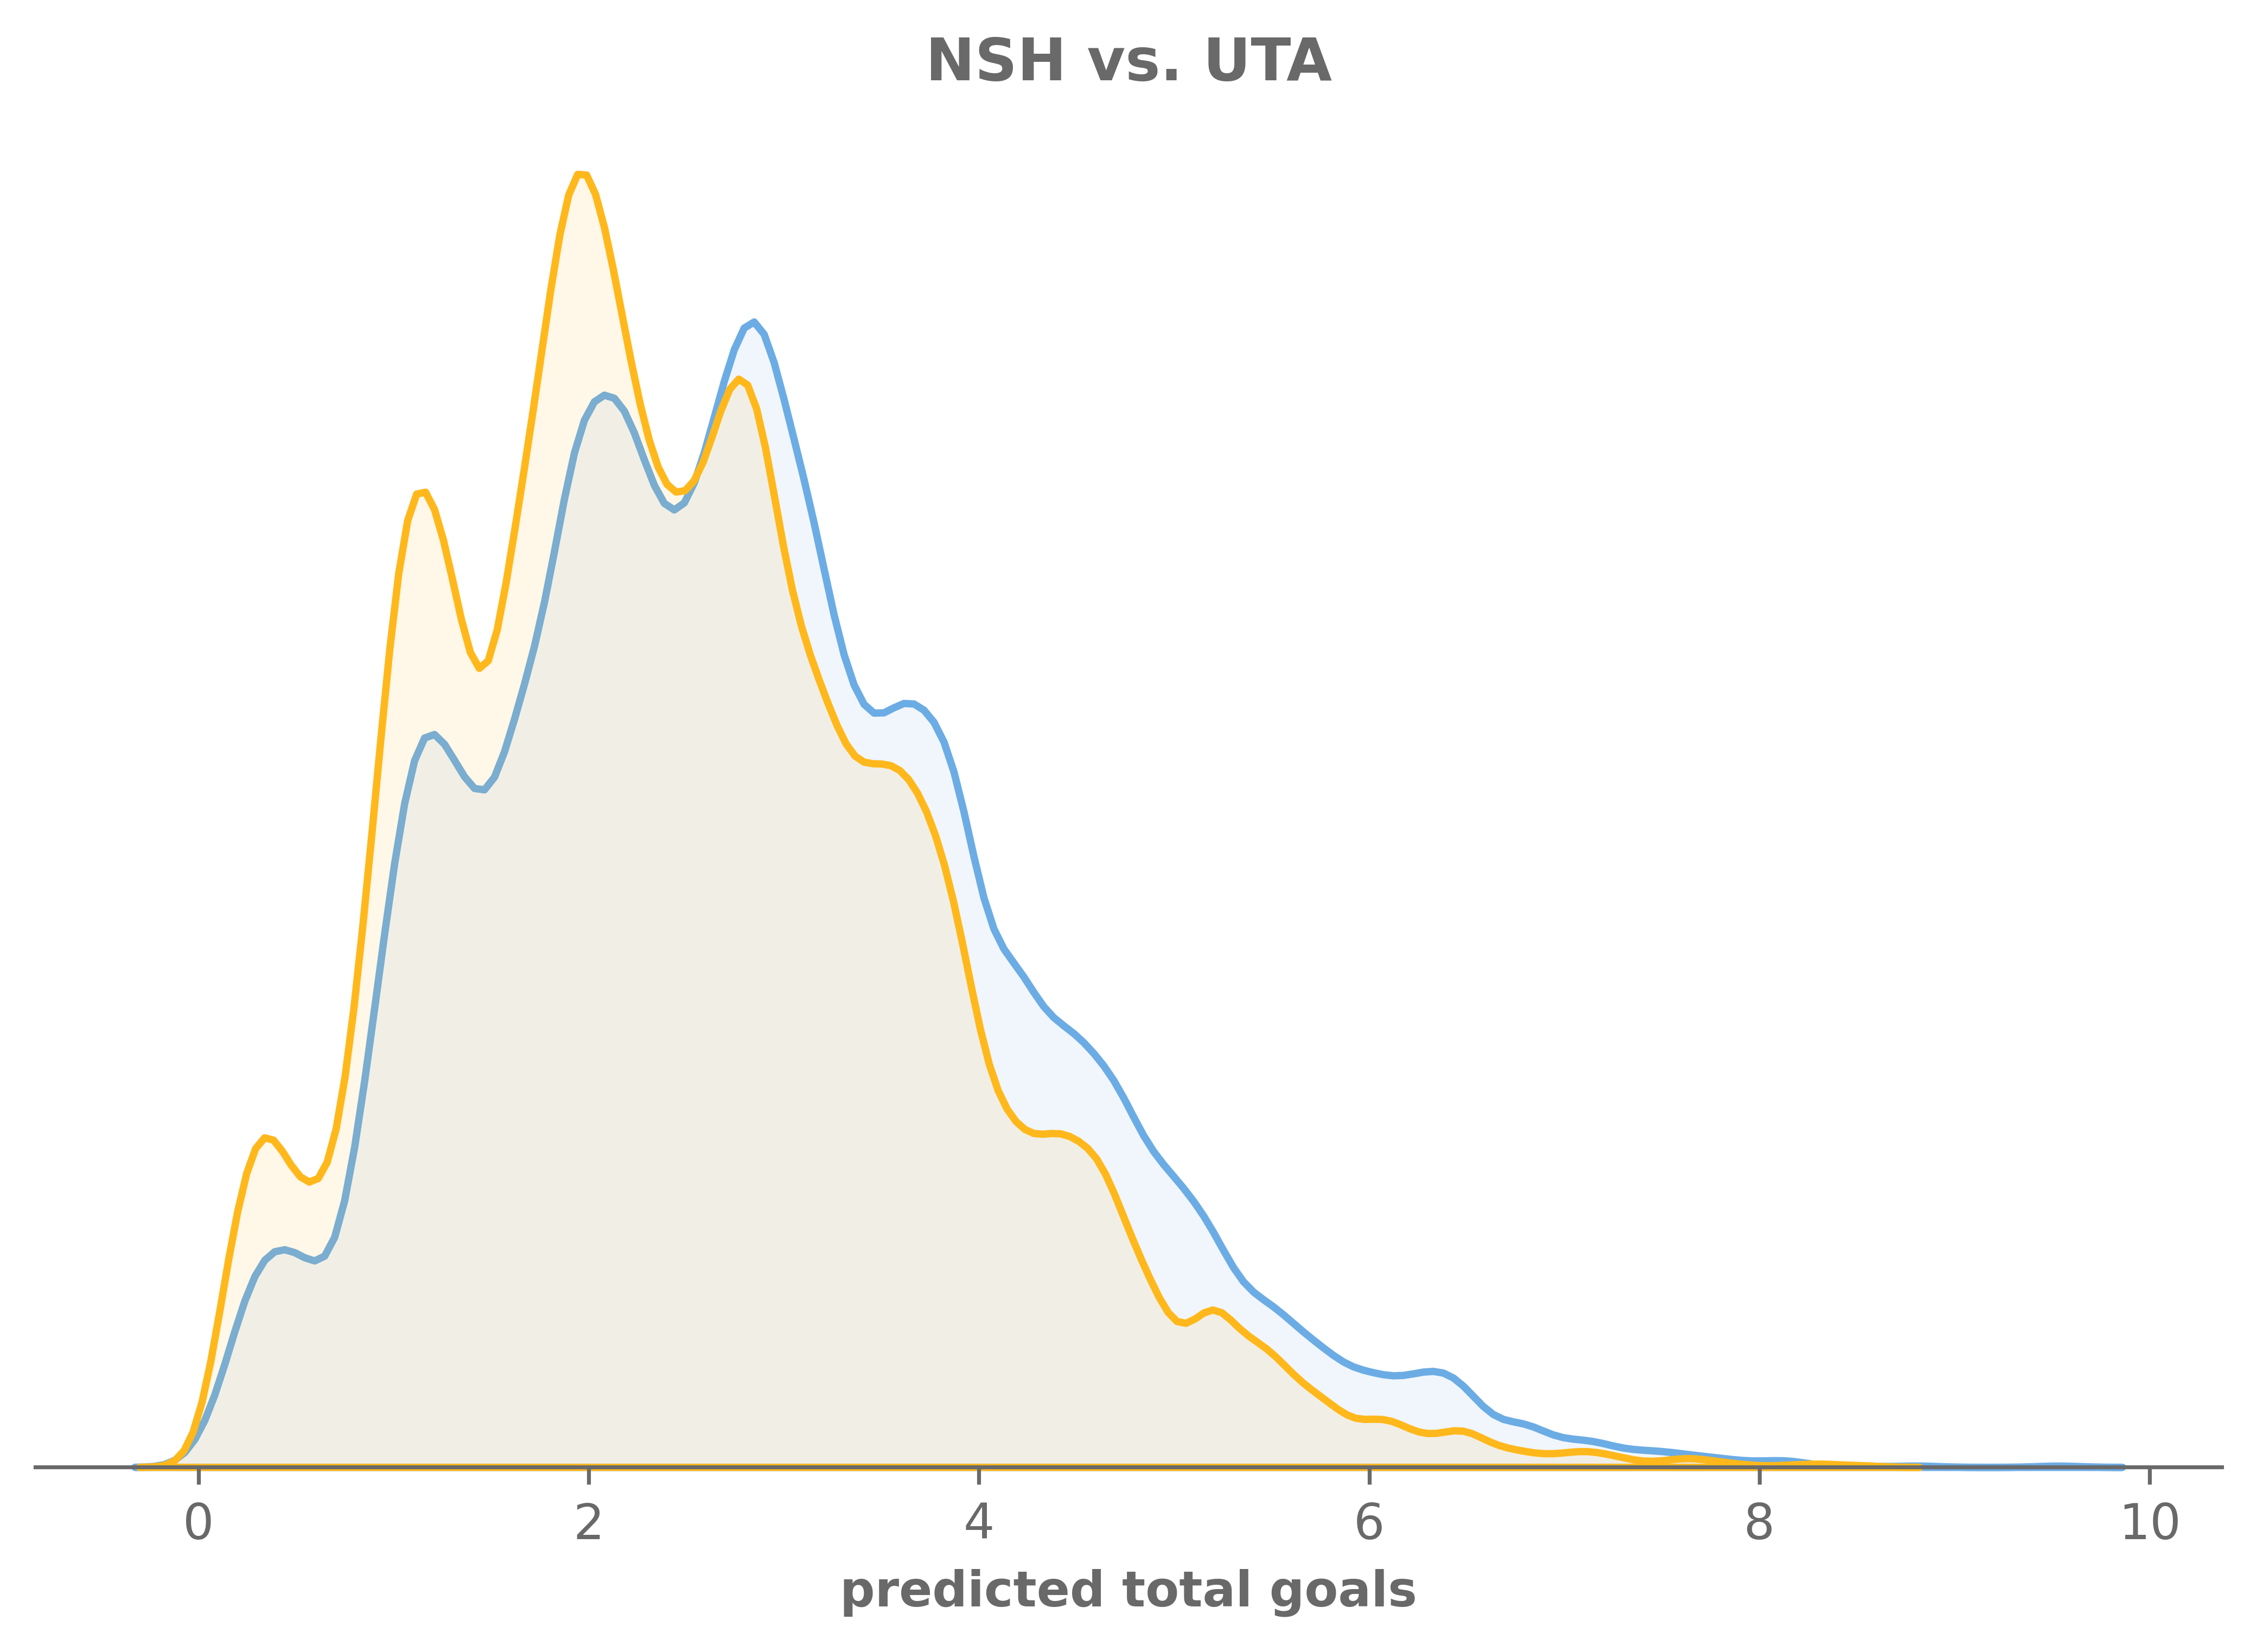

In [ ]:
dpi = 650
figsize = (8, 5)
nrows = 1  # len(assessed_predictions["home_team"].to_list())
ncols = 1

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=dpi, sharex=True, sharey=True)

for idx, game in enumerate(
    assessed_predictions.filter(pl.col("home_team") == "NSH").sort("predicted_home_total_goals_mean").to_dicts()
):
    # ax = axs[idx]

    plot_predictions = predictions.filter(pl.col("game_id") == game["game_id"])

    venues = ["away", "home"]

    for venue in venues:
        sns.kdeplot(
            data=plot_predictions,
            x=plot_predictions[f"predicted_{venue}_total_goals"],
            bw_adjust=0.5,
            clip_on=False,
            fill=True,
            alpha=0.1,
            linewidth=1.5,
            hue=plot_predictions[f"{venue}_team"],
            palette=color_dict,
            legend=False,
            ax=ax,
        )

    sns.despine(left=True)

    ax.set(yticks=[], ylabel="", xlabel="predicted total goals")

    if idx != (nrows - 1):
        ax.set(xticks=[])

    # else:
    #     ax.set(xlabel="predicted total goals")

    ax.set_title(f"{game['home_team']} vs. {game['away_team']}")

fig.savefig(f"./charts/{latest_date}_NSH.png", dpi=650, bbox_inches="tight", facecolor="white")

### Plotting today's games
Plotting the predicted goals for all of today's games

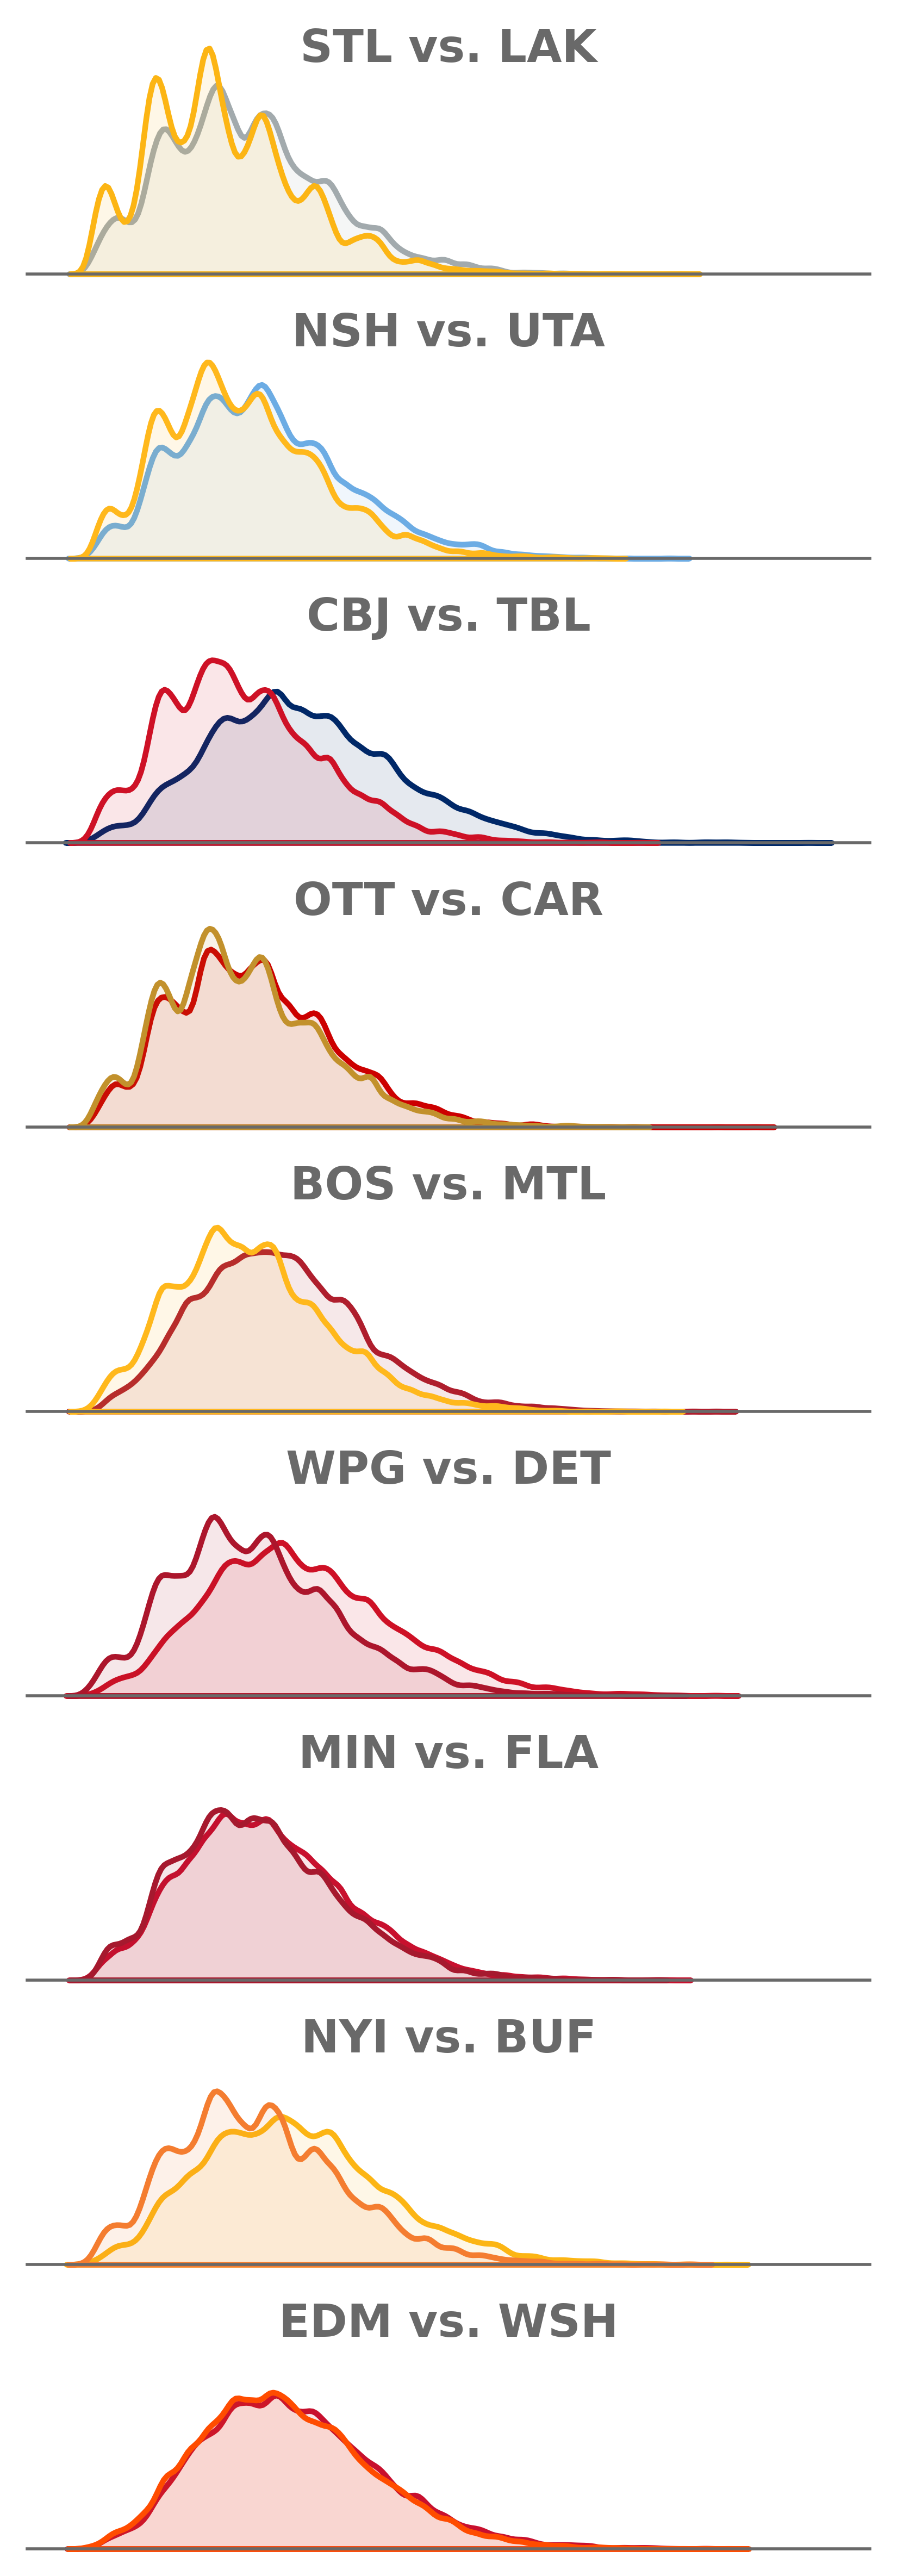

In [ ]:
dpi = 500
figsize = (4, 12)
nrows = len(assessed_predictions["home_team"].to_list())
ncols = 1

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=dpi, sharex=True, sharey=True)

for idx, game in enumerate(assessed_predictions.sort("predicted_home_total_goals_mean").to_dicts()):
    ax = axs[idx]

    plot_predictions = predictions.filter(pl.col("game_id") == game["game_id"])

    venues = ["away", "home"]

    for venue in venues:
        sns.kdeplot(
            data=plot_predictions,
            x=plot_predictions[f"predicted_{venue}_total_goals"],
            bw_adjust=0.5,
            clip_on=False,
            fill=True,
            alpha=0.1,
            linewidth=1.5,
            hue=plot_predictions[f"{venue}_team"],
            palette=color_dict,
            legend=False,
            ax=ax,
        )

    sns.despine(left=True)

    ax.set(yticks=[], ylabel="")

    if idx != (nrows - 1):
        ax.set(xticks=[])

    # else:
    #     ax.set(xlabel="predicted total goals")

    ax.set_title(f"{game['home_team']} vs. {game['away_team']}", y=0.8)

fig.savefig(f"./charts/{latest_date}.png", dpi=650, bbox_inches="tight", facecolor="white")